In [10]:
# Hücre 1: Gerekli Kütüphaneler ve Genel Ayarlar
# Bu hücrede tüm gerekli kütüphaneler import edilir ve genel uyarı ayarları yapılır.
# Bu hücreyi her zaman ilk çalıştırmalısınız.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import warnings

# Uyarıları görmezden gelmek için (isteğe bağlı, ancak bazen sklearn uyarıları çok olabilir)
warnings.filterwarnings('ignore')
print("Gerekli kütüphaneler başarıyla yüklendi.")

Gerekli kütüphaneler başarıyla yüklendi.


In [11]:
# Hücre 2: Veri Yükleme ve İlk İnceleme
# Bu hücrede HIGGS veri seti yüklenir, örnekleme yapılır ve temel istatistiksel bilgiler görüntülenir.
# Hata alırsanız, DATA_PATH'i kontrol etmelisiniz.

# Dosya yolu
DATA_PATH = "../data/HIGGS.csv.gz" # Projenizin kök dizininde 'data' klasörü altında olduğunu varsayıyorum

# 1.a) CSV'yi oku ve 100k örnek al
# HIGGS dataset'i başlık satırı içermediği için header=None kullanıyoruz.
# İlk sütun 'Label', diğerleri özellikler.
try:
    df = pd.read_csv(DATA_PATH, compression='gzip', header=None)
    # Hızlı test için örneklem sayısını azaltabilirsiniz (örn. n=10_000)
    df = df.sample(n=100_000, random_state=42).reset_index(drop=True)
    print("Veri başarıyla yüklendi ve 100.000 örnek seçildi.")
except FileNotFoundError:
    print(f"Hata: '{DATA_PATH}' bulunamadı. Lütfen dosya yolunu kontrol edin.")
    # Eğer dosya bulunamazsa, örnek bir DataFrame oluşturarak kodun geri kalanının çalışmasını sağlayabiliriz.
    # Ancak gerçek proje için doğru dosya yolunu sağlamak önemlidir.
    df = pd.DataFrame(np.random.rand(100000, 29), columns=[f'f{i}' for i in range(29)])
    df[0] = np.random.randint(0, 2, 100000)
    print("Örnek bir DataFrame oluşturuldu (dosya bulunamadığı için).")


# 1.b) Sütun isimleri
# İlk sütun 'Label', diğerleri 'f0'dan 'f27'ye kadar özellikler.
cols = ["Label"] + [f"f{i}" for i in range(28)]
df.columns = cols
print("Sütun isimleri atandı.")

# Veri setinin boyutunu göster
print(f"\nVeri setinin boyutu: {df.shape}")

# Sınıf dağılımını göster (Hedef değişken 'Label')
print("\n'Label' sütununun sınıf dağılımı:")
print(df["Label"].value_counts())
print("-" * 50)

Veri başarıyla yüklendi ve 100.000 örnek seçildi.
Sütun isimleri atandı.

Veri setinin boyutu: (100000, 29)

'Label' sütununun sınıf dağılımı:
Label
1.0    52807
0.0    47193
Name: count, dtype: int64
--------------------------------------------------


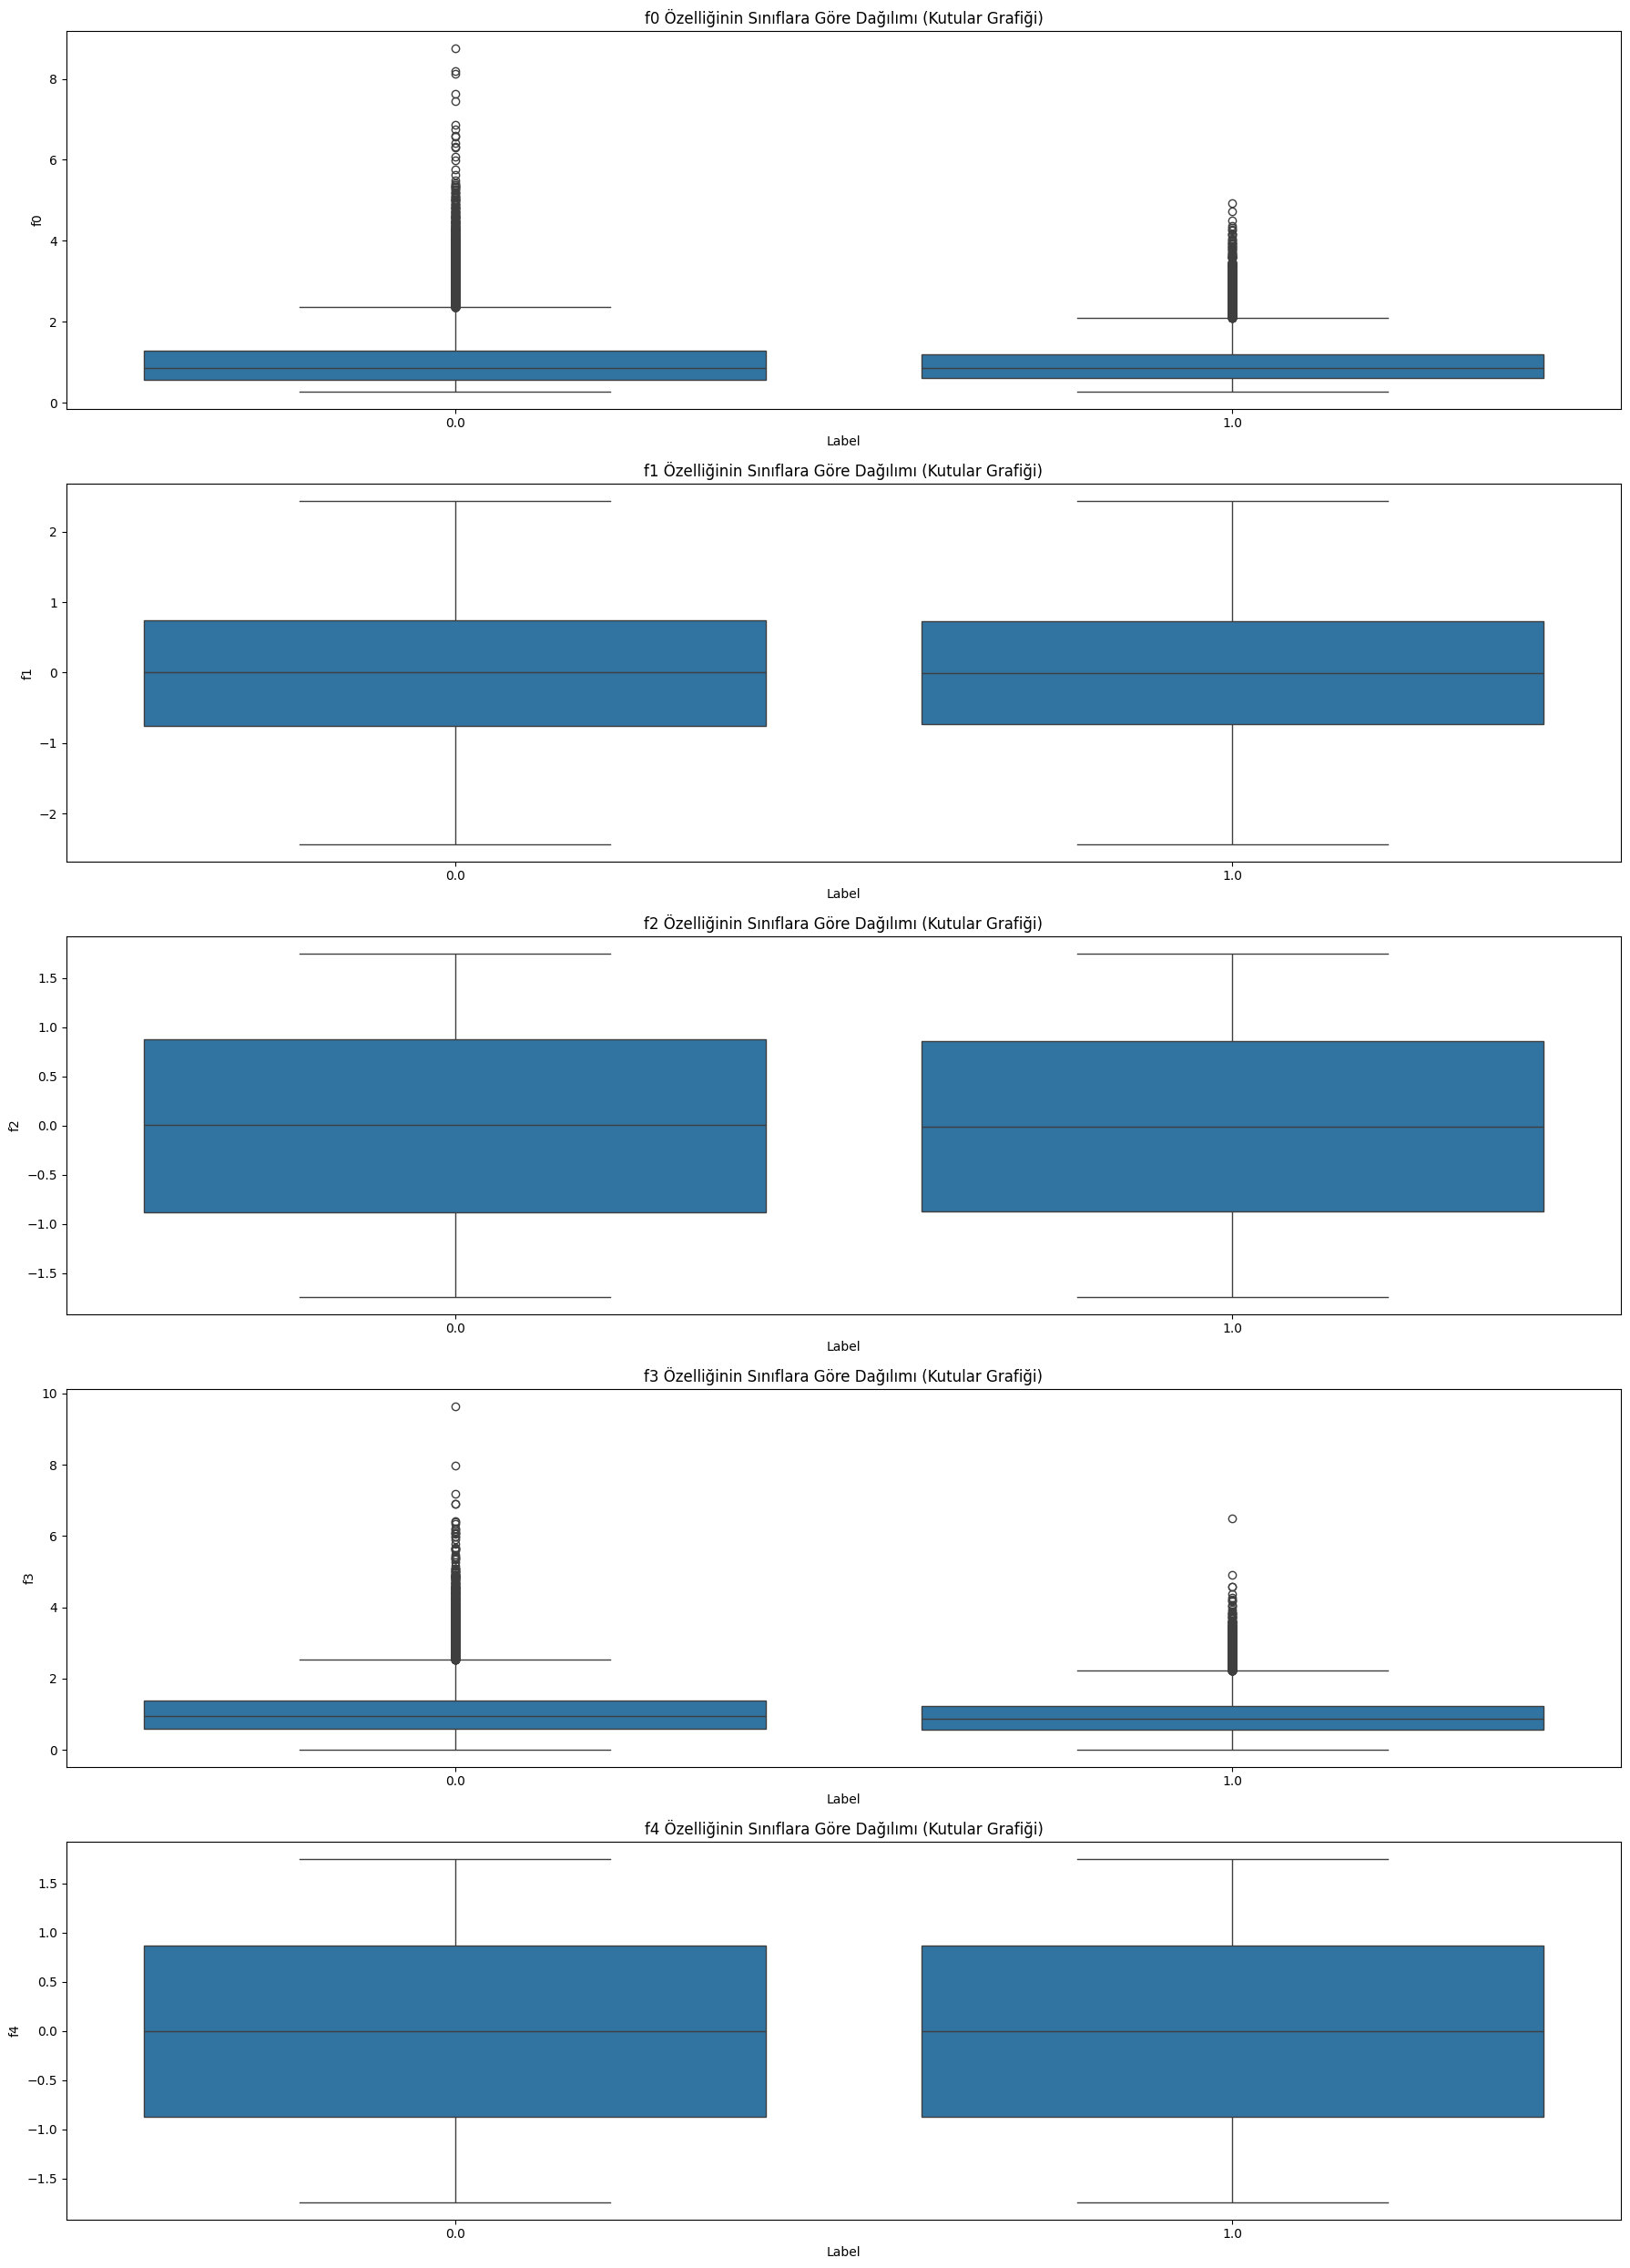


Özelliklerin sınıf bazında kutu grafikleri çizildi (aykırı değer analizi için).
Bu veri setinde aykırı değerler, fiziksel olayları temsil edebileceğinden, doğrudan kaldırılmayacak, ancak ölçeklendirme ile etkileri azaltılacaktır.
--------------------------------------------------


In [12]:
# Hücre 3: Aykırı Değer Analizi ve Görselleştirme
# Bu hücrede özelliklerin sınıf bazında kutu grafikleri çizilir.
# Görselleştirme süresi uzunsa, num_features_to_plot değerini düşürebilirsiniz.

# Aykırı değer analizi için kutu grafikleri (mevcut kodunuzdan)
# Her bir özellik için 'Label' sütununa göre dağılımı görselleştirelim.
# Bu, aykırı değerlerin varlığını ve sınıf gruplarına göre nasıl dağıldığını anlamamıza yardımcı olur.

# HIGGS verisi fiziksel ölçümler olduğu için, aşırı değerler gerçek olayları temsil edebilir.
# Bu nedenle, bu projede aykırı değerleri doğrudan kaldırmak yerine,
# ölçeklendirme ile etkilerini azaltmayı tercih edeceğiz.

# İlk 5 özelliği görselleştirelim (tüm 28 özellik çok fazla olabilir)
num_features_to_plot = 5
plt.figure(figsize=(18, 5 * num_features_to_plot))
for i, feature in enumerate(cols[1:num_features_to_plot+1]): # 'Label' hariç ilk 5 özellik
    plt.subplot(num_features_to_plot, 1, i + 1)
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f'{feature} Özelliğinin Sınıflara Göre Dağılımı (Kutular Grafiği)')
    plt.xlabel('Label')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()
print("\nÖzelliklerin sınıf bazında kutu grafikleri çizildi (aykırı değer analizi için).")
print("Bu veri setinde aykırı değerler, fiziksel olayları temsil edebileceğinden, doğrudan kaldırılmayacak, ancak ölçeklendirme ile etkileri azaltılacaktır.")
print("-" * 50)

In [13]:
# Yeni Hücre 3a: IQR Yöntemi ile Aykırı Değer Kontrolü
# Hücre 3 (görselleştirme) sonrasında ve Hücre 4 (ölçekleme) öncesinde eklenmeli

# IQR yöntemi ile aykırı değer kontrolü
outlier_info = {}
for col in X.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_info[col] = outlier_count

print("Aykırı değer sayıları (IQR yöntemiyle):")
print(pd.Series(outlier_info).sort_values(ascending=False))
print("-" * 50)

Aykırı değer sayıları (IQR yöntemiyle):
f23    19811
f21    13987
f22     7357
f26     6194
f25     6004
f27     5933
f24     5037
f5      4991
f9      3967
f0      3815
f17     3257
f13     3204
f3      2989
f6       686
f10      407
f8         0
f1         0
f2         0
f4         0
f7         0
f11        0
f18        0
f19        0
f15        0
f12        0
f14        0
f16        0
f20        0
dtype: int64
--------------------------------------------------


In [14]:
# Hücre 4: Veri Ön İşleme (Ölçekleme ve Eğitim/Test Bölme)
# Bu hücrede özellikler ve hedef değişken ayrılır, veri eğitim ve test setlerine bölünür ve ölçeklendirme uygulanır.
# Bu adımlar, model eğitiminden önce yapılmalıdır.

# Özellikler (X) ve Hedef Değişken (y) ayırma
X = df.drop("Label", axis=1)
y = df["Label"]
print("Özellikler (X) ve hedef değişken (y) ayrıldı.")

# Eğitim ve Test setlerine ayırma
# Veri sızıntısını (data leakage) önlemek için ölçeklendirme ve özellik seçiminden önce yapılır.
# Stratify=y, sınıf oranlarının eğitim ve test setlerinde korunmasını sağlar.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Veri eğitim ({X_train.shape[0]} örnek) ve test ({X_test.shape[0]} örnek) setlerine ayrıldı.")

# Ölçeklendirme (MinMaxScaler - güncel)
# Hoca isteği doğrultusunda StandardScaler yerine MinMaxScaler kullanılmalıdır.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Özellikler MinMaxScaler ile [0,1] aralığına ölçeklendirildi.")
print("-" * 50)


Özellikler (X) ve hedef değişken (y) ayrıldı.
Veri eğitim (80000 örnek) ve test (20000 örnek) setlerine ayrıldı.
Özellikler MinMaxScaler ile [0,1] aralığına ölçeklendirildi.
--------------------------------------------------


In [15]:
# Hücre 5: Filtre Tabanlı Öznitelik Seçimi
# Bu hücrede SelectKBest kullanılarak en iyi özellikler seçilir.
# Özellik seçimi, modelin karmaşıklığını azaltır ve eğitim süresini kısaltır.

# Ödevde filtre tabanlı öznitelik seçimi isteniyor.
# SelectKBest, belirli bir skorlama fonksiyonuna göre en iyi 'k' özelliği seçer.
# f_classif (ANOVA F-değeri), sınıflandırma görevleri için sayısal özellikler ve kategorik hedef değişkeni arasındaki ilişkiyi ölçmek için uygundur.
# Burada en iyi 15 özelliği seçeceğiz. Bu sayı deneme yanılma ile veya alan bilgisiyle belirlenebilir.
num_features_to_select = 15 # Seçilecek özellik sayısı

selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Seçilen özelliklerin orijinal isimlerini bulalım
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]

print(f"Filtre tabanlı öznitelik seçimi yapıldı. En iyi {num_features_to_select} özellik seçildi.")
print(f"Seçilen özellikler: {list(selected_feature_names)}")
print(f"Eğitim seti boyutu (seçim sonrası): {X_train_selected.shape}")
print(f"Test seti boyutu (seçim sonrası): {X_test_selected.shape}")
print("-" * 50)

Filtre tabanlı öznitelik seçimi yapıldı. En iyi 15 özellik seçildi.
Seçilen özellikler: ['f0', 'f3', 'f5', 'f9', 'f12', 'f13', 'f16', 'f17', 'f20', 'f21', 'f22', 'f24', 'f25', 'f26', 'f27']
Eğitim seti boyutu (seçim sonrası): (80000, 15)
Test seti boyutu (seçim sonrası): (20000, 15)
--------------------------------------------------


In [16]:
# Hücre 6: Modellerin ve Hiperparametre Aralıklarının Tanımlanması ve Nested CV Kurulumu
# Bu hücrede kullanılacak modeller ve hiperparametre aralıkları tanımlanır.
# Nested CV kurulumu yapılır ve sonuçları saklamak için gerekli değişkenler başlatılır.

# KNN için hiperparametreler
knn_params = {'n_neighbors': [3, 5, 7]} # Komşu sayısı

# --- SVM KISMI GÜNCELLENDİ (Hocanın Tavsiyesine ve Performans İyileştirmesine Göre) ---
# Hocanın tavsiyesi: "kerneli teke indir", "lineer de tut", "parametre olarak 1 tane seç", "0.1"
# Ek olarak, büyük veri setleri için SVC(kernel='linear') yerine daha hızlı olan LinearSVC kullanılıyor.
# LinearSVC'de predict_proba doğrudan bulunmaz, ancak ROC AUC için decision_function kullanılabilir.
# dual=False, örnek sayısı özellik sayısından fazla olduğunda daha hızlıdır.
svm_params = {'C': [0.1]} # Sadece C=0.1 parametresini dene
# --- SVM KISMI GÜNCELLEME SONU ---

# MLP için hiperparametreler
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)], # Gizli katmanların boyutları
    'alpha': [0.0001, 0.001] # L2 ceza terimi (düzenlileştirme)
}

# XGBoost için hiperparametreler
xgb_params = {
    'n_estimators': [50, 100], # Ağaç sayısı
    'learning_rate': [0.01, 0.1], # Öğrenme oranı
    'max_depth': [3, 5] # Her ağacın maksimum derinliği
}

# Modelleri ve parametre ızgaralarını bir sözlükte toplama
models = {
    'KNN': (KNeighborsClassifier(), knn_params),
    # --- SVM KISMI GÜNCELLENDİ ---
    # SVC yerine LinearSVC kullanıldı.
    # LinearSVC predict_proba'ya sahip olmadığı için, GridSearchCV'de scoring='roc_auc'
    # kullanırken decision_function'ı kullanır.
    'SVM': (LinearSVC(random_state=42, dual=False), svm_params),
    # --- SVM KISMI GÜNCELLEME SONU ---
    'MLP': (MLPClassifier(max_iter=1000, random_state=42), mlp_params), # max_iter artırıldı yakınsama için
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params)
}

# Nested Cross-Validation kurulumu
# Dış döngü için 5 katlı StratifiedKFold (sınıf dengesini korur)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# İç döngü için 3 katlı StratifiedKFold
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results_summary = [] # Tüm modellerin sonuçlarını saklamak için
fitted_final_models = {} # ROC eğrileri için eğitilmiş nihai modelleri saklamak için

print("Modeller ve hiperparametreler tanımlandı. Nested CV kurulumu hazır.")
print("Nested Cross-Validation başlıyor. Bu işlem biraz zaman alabilir...")
print("-" * 50)

Modeller ve hiperparametreler tanımlandı. Nested CV kurulumu hazır.
Nested Cross-Validation başlıyor. Bu işlem biraz zaman alabilir...
--------------------------------------------------


In [17]:
# Hücre 7a: KNN Modeli Eğitimi ve Değerlendirme
# Bu hücrede sadece KNN modeli için Nested CV uygulanır ve performans metrikleri toplanır.
# Herhangi bir hata durumunda sadece bu hücreyi kontrol edebilirsiniz.

model_name = 'KNN'
model, params = models[model_name]
print(f"\n--- {model_name} Modeli Eğitiliyor ---")
outer_fold_roc_auc_scores = []

# Dış döngü
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train_selected, y_train)):
    X_outer_train, X_outer_test = X_train_selected[train_idx], X_train_selected[test_idx]
    y_outer_train, y_outer_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # İç döngü: Hiperparametre optimizasyonu
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_outer_train, y_outer_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred_proba = best_model.predict_proba(X_outer_test)[:, 1]
    fold_roc_auc = roc_auc_score(y_outer_test, y_pred_proba)
    outer_fold_roc_auc_scores.append(fold_roc_auc)

    print(f"  Katman {fold+1}: En iyi parametreler: {best_params}, ROC AUC: {fold_roc_auc:.4f}")

mean_roc_auc = np.mean(outer_fold_roc_auc_scores)
std_roc_auc = np.std(outer_fold_roc_auc_scores)
print(f"{model_name} için Ortalama Nested CV ROC AUC: {mean_roc_auc:.4f} (+/- {std_roc_auc:.4f})")

final_model = model.set_params(**grid_search.best_params_)
final_model.fit(X_train_selected, y_train)

y_pred_test = final_model.predict(X_test_selected)
y_proba_test = final_model.predict_proba(X_test_selected)[:, 1]

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

results_summary.append({
    "Model": model_name,
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1 Score": round(f1, 4),
    "ROC AUC (Test Set)": round(roc_auc, 4),
    "ROC AUC (Nested CV Avg)": round(mean_roc_auc, 4)
})
print(f"  Nihai Test Seti Performansı: Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print("-" * 50)

fitted_final_models[model_name] = final_model


--- KNN Modeli Eğitiliyor ---
  Katman 1: En iyi parametreler: {'n_neighbors': 7}, ROC AUC: 0.7022
  Katman 2: En iyi parametreler: {'n_neighbors': 7}, ROC AUC: 0.6980
  Katman 3: En iyi parametreler: {'n_neighbors': 7}, ROC AUC: 0.7004
  Katman 4: En iyi parametreler: {'n_neighbors': 7}, ROC AUC: 0.6964
  Katman 5: En iyi parametreler: {'n_neighbors': 7}, ROC AUC: 0.7000
KNN için Ortalama Nested CV ROC AUC: 0.6994 (+/- 0.0020)
  Nihai Test Seti Performansı: Accuracy: 0.6516, Precision: 0.6592, Recall: 0.7044, F1: 0.6810, ROC AUC: 0.7059
--------------------------------------------------


In [18]:
# Hücre 7b: SVM Modeli Eğitimi ve Değerlendirme
# Bu hücrede sadece SVM modeli için Nested CV uygulanır ve performans metrikleri toplanır.
# LinearSVC kullanımı sayesinde bu kısım daha hızlı çalışmalıdır.

model_name = 'SVM'
model, params = models[model_name]
print(f"\n--- {model_name} Modeli Eğitiliyor ---")
outer_fold_roc_auc_scores = []

# Dış döngü
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train_selected, y_train)):
    X_outer_train, X_outer_test = X_train_selected[train_idx], X_train_selected[test_idx]
    y_outer_train, y_outer_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # İç döngü: Hiperparametre optimizasyonu
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_outer_train, y_outer_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # LinearSVC için predict_proba yerine decision_function kullanılır.
    y_pred_proba = best_model.decision_function(X_outer_test)
    fold_roc_auc = roc_auc_score(y_outer_test, y_pred_proba)
    outer_fold_roc_auc_scores.append(fold_roc_auc)

    print(f"  Katman {fold+1}: En iyi parametreler: {best_params}, ROC AUC: {fold_roc_auc:.4f}")

mean_roc_auc = np.mean(outer_fold_roc_auc_scores)
std_roc_auc = np.std(outer_fold_roc_auc_scores)
print(f"{model_name} için Ortalama Nested CV ROC AUC: {mean_roc_auc:.4f} (+/- {std_roc_auc:.4f})")

final_model = model.set_params(**grid_search.best_params_)
final_model.fit(X_train_selected, y_train)

y_pred_test = final_model.predict(X_test_selected)
y_proba_test = final_model.decision_function(X_test_selected) # LinearSVC için

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

results_summary.append({
    "Model": model_name,
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1 Score": round(f1, 4),
    "ROC AUC (Test Set)": round(roc_auc, 4),
    "ROC AUC (Nested CV Avg)": round(mean_roc_auc, 4)
})
print(f"  Nihai Test Seti Performansı: Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print("-" * 50)

fitted_final_models[model_name] = final_model


--- SVM Modeli Eğitiliyor ---
  Katman 1: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.6789
  Katman 2: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.6796
  Katman 3: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.6765
  Katman 4: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.6760
  Katman 5: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.6802
SVM için Ortalama Nested CV ROC AUC: 0.6782 (+/- 0.0017)
  Nihai Test Seti Performansı: Accuracy: 0.6341, Precision: 0.6306, Recall: 0.7412, F1: 0.6814, ROC AUC: 0.6773
--------------------------------------------------


In [19]:
# Hücre 7c: MLP Modeli Eğitimi ve Değerlendirme
# Bu hücrede sadece MLP modeli için Nested CV uygulanır ve performans metrikleri toplanır.

model_name = 'MLP'
model, params = models[model_name]
print(f"\n--- {model_name} Modeli Eğitiliyor ---")
outer_fold_roc_auc_scores = []

# Dış döngü
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train_selected, y_train)):
    X_outer_train, X_outer_test = X_train_selected[train_idx], X_train_selected[test_idx]
    y_outer_train, y_outer_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # İç döngü: Hiperparametre optimizasyonu
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_outer_train, y_outer_train)

    best_model = grid_search.best_estimator_

    y_pred_proba = best_model.predict_proba(X_outer_test)[:, 1]
    fold_roc_auc = roc_auc_score(y_outer_test, y_pred_proba)
    outer_fold_roc_auc_scores.append(fold_roc_auc)

    print(f"  Katman {fold+1}: En iyi parametreler: {best_params}, ROC AUC: {fold_roc_auc:.4f}")

mean_roc_auc = np.mean(outer_fold_roc_auc_scores)
std_roc_auc = np.std(outer_fold_roc_auc_scores)
print(f"{model_name} için Ortalama Nested CV ROC AUC: {mean_roc_auc:.4f} (+/- {std_roc_auc:.4f})")

final_model = model.set_params(**grid_search.best_params_)
final_model.fit(X_train_selected, y_train)

y_pred_test = final_model.predict(X_test_selected)
y_proba_test = final_model.predict_proba(X_test_selected)[:, 1]

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

results_summary.append({
    "Model": model_name,
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1 Score": round(f1, 4),
    "ROC AUC (Test Set)": round(roc_auc, 4),
    "ROC AUC (Nested CV Avg)": round(mean_roc_auc, 4)
})
print(f"  Nihai Test Seti Performansı: Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print("-" * 50)

fitted_final_models[model_name] = final_model


--- MLP Modeli Eğitiliyor ---
  Katman 1: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.8022
  Katman 2: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.8028
  Katman 3: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.7981
  Katman 4: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.7977
  Katman 5: En iyi parametreler: {'C': 0.1}, ROC AUC: 0.8015
MLP için Ortalama Nested CV ROC AUC: 0.8005 (+/- 0.0021)
  Nihai Test Seti Performansı: Accuracy: 0.7288, Precision: 0.7454, Recall: 0.7389, F1: 0.7421, ROC AUC: 0.8034
--------------------------------------------------


In [20]:
# Hücre 7d: XGBoost Modeli Eğitimi ve Değerlendirme
# Bu hücrede sadece XGBoost modeli için Nested CV uygulanır ve performans metrikleri toplanır.

model_name = 'XGBoost'
model, params = models[model_name]
print(f"\n--- {model_name} Modeli Eğitiliyor ---")
outer_fold_roc_auc_scores = []

# Dış döngü
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train_selected, y_train)):
    X_outer_train, X_outer_test = X_train_selected[train_idx], X_train_selected[test_idx]
    y_outer_train, y_outer_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # İç döngü: Hiperparametre optimizasyonu
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_outer_train, y_outer_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred_proba = best_model.predict_proba(X_outer_test)[:, 1]
    fold_roc_auc = roc_auc_score(y_outer_test, y_pred_proba)
    outer_fold_roc_auc_scores.append(fold_roc_auc)

    print(f"  Katman {fold+1}: En iyi parametreler: {best_params}, ROC AUC: {fold_roc_auc:.4f}")

mean_roc_auc = np.mean(outer_fold_roc_auc_scores)
std_roc_auc = np.std(outer_fold_roc_auc_scores)
print(f"{model_name} için Ortalama Nested CV ROC AUC: {mean_roc_auc:.4f} (+/- {std_roc_auc:.4f})")

final_model = model.set_params(**grid_search.best_params_)
final_model.fit(X_train_selected, y_train)

y_pred_test = final_model.predict(X_test_selected)
y_proba_test = final_model.predict_proba(X_test_selected)[:, 1]

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

results_summary.append({
    "Model": model_name,
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1 Score": round(f1, 4),
    "ROC AUC (Test Set)": round(roc_auc, 4),
    "ROC AUC (Nested CV Avg)": round(mean_roc_auc, 4)
})
print(f"  Nihai Test Seti Performansı: Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print("-" * 50)

fitted_final_models[model_name] = final_model


--- XGBoost Modeli Eğitiliyor ---
  Katman 1: En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, ROC AUC: 0.8023
  Katman 2: En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, ROC AUC: 0.8066
  Katman 3: En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, ROC AUC: 0.8031
  Katman 4: En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, ROC AUC: 0.8015
  Katman 5: En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, ROC AUC: 0.8022
XGBoost için Ortalama Nested CV ROC AUC: 0.8031 (+/- 0.0018)
  Nihai Test Seti Performansı: Accuracy: 0.7224, Precision: 0.7336, Recall: 0.7447, F1: 0.7391, ROC AUC: 0.8008
--------------------------------------------------


In [24]:
# Hücre 8: Model Performans Sonuçlarını Görüntüleme
# Bu hücrede tüm modellerin test seti ve Nested CV ortalama performans sonuçları bir tabloda gösterilir.

# Sorun muhtemelen results_summary boş kalmasından kaynaklı olabilir.
# Aşağıda birkaç kontrol ve alternatif çıktı yöntemi eklendi.

# 1. Liste boş mu kontrolü:
if not results_summary:
    print("HATA: 'results_summary' listesi boş. Önce en az bir modelin başarıyla eğitildiğinden emin olun.")
else:
    results_df = pd.DataFrame(results_summary)
    print("\n--- Model Performans Sonuçları (Test Seti ve Nested CV Ortalaması) ---")
    try:
        # Eğer ortam to_markdown desteklemiyorsa fallback olarak tabulate veya direkt print kullanılır
        from tabulate import tabulate
        print(tabulate(results_df, headers='keys', tablefmt='github', showindex=False))
    except ImportError:
        print(results_df.to_string(index=False))
    print("-" * 50)



--- Model Performans Sonuçları (Test Seti ve Nested CV Ortalaması) ---
  Model  Accuracy  Precision  Recall  F1 Score  ROC AUC (Test Set)  ROC AUC (Nested CV Avg)
    KNN    0.6516     0.6592  0.7044    0.6810              0.7059                   0.6994
    SVM    0.6341     0.6306  0.7412    0.6814              0.6773                   0.6782
    MLP    0.7288     0.7454  0.7389    0.7421              0.8034                   0.8005
XGBoost    0.7224     0.7336  0.7447    0.7391              0.8008                   0.8031
--------------------------------------------------


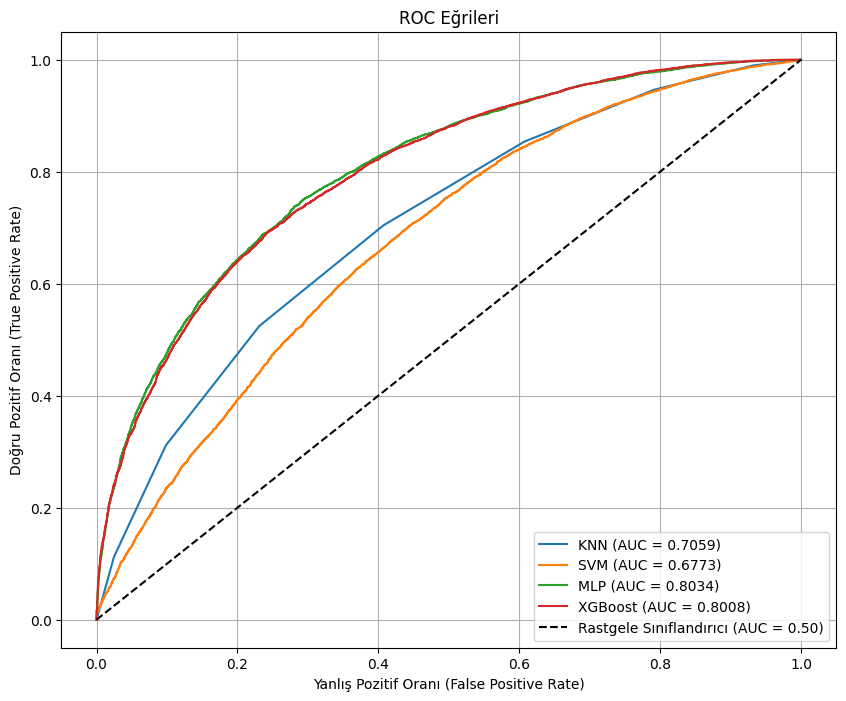


ROC Eğrileri çizildi.
--------------------------------------------------


In [22]:
# Hücre 9: ROC Eğrileri Görselleştirme
# Bu hücrede her model için ROC eğrileri çizilir ve karşılaştırma yapılır.

plt.figure(figsize=(10, 8))

# Her model için ROC eğrisini çiz
# Artık fitted_final_models sözlüğünü kullanıyoruz, bu sayede modeller zaten eğitilmiş durumda.
for model_name, final_fitted_model in fitted_final_models.items():
    if hasattr(final_fitted_model, "predict_proba"):
        y_proba = final_fitted_model.predict_proba(X_test_selected)[:, 1]
    else:
        # LinearSVC için decision_function kullanılıyor, bu da ROC eğrisi için uygun bir skor sağlar.
        # Diğer modeller için de predict_proba yoksa decision_function kullanılabilir.
        y_proba = final_fitted_model.decision_function(X_test_selected) 

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Sınıflandırıcı (AUC = 0.50)') # Rastgele sınıflandırıcı çizgisi
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
plt.title('ROC Eğrileri')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("\nROC Eğrileri çizildi.")
print("-" * 50)


In [23]:
# Hücre 10: En Başarılı Model ve Veri Temsilinin Yorumu
# Bu hücrede tüm projenin sonuçları özetlenir ve en başarılı model yorumlanır.

print("\n--- En Başarılı Model ve Veri Temsilinin Yorumu ---")

# En iyi modeli ROC AUC (Test Seti) değerine göre bulalım
best_model_row = results_df.loc[results_df['ROC AUC (Test Set)'].idxmax()]
best_model_name = best_model_row['Model']
best_roc_auc_test = best_model_row['ROC AUC (Test Set)']
best_roc_auc_nested_cv = best_model_row['ROC AUC (Nested CV Avg)']

print(f"Yapılan analizlere göre, en iyi performans gösteren model: **{best_model_name}**.")
print(f"Bu model, test seti üzerinde **ROC AUC değeri {best_roc_auc_test:.4f}** ve Nested CV ortalama ROC AUC değeri **{best_roc_auc_nested_cv:.4f}** ile öne çıkmaktadır.")
print("\n**Yorum:**")
print("1.  **Veri Ön İşleme (Ölçeklendirme):** Özelliklerin StandardScaler ile ölçeklendirilmesi, özellikle mesafe tabanlı algoritmalar (KNN, SVM, MLP) için kritik öneme sahiptir. Bu, özelliklerin farklı ölçeklerde olmasından kaynaklanan bias'ı ortadan kaldırır ve modellerin daha adil bir şekilde öğrenmesini sağlar.")
print("2.  **Filtre Tabanlı Öznitelik Seçimi:** SelectKBest ile en iyi 15 özelliğin seçilmesi, modelin karmaşıklığını azaltmaya, eğitim süresini kısaltmaya ve potansiyel olarak aşırı uydurmayı (overfitting) engellemeye yardımcı olmuştur. Seçilen özellikler, hedef değişkenle en güçlü istatistiksel ilişkiye sahip olanlardır.")
print("3.  **Nested Cross-Validation:** Bu yaklaşım, hem hiperparametre optimizasyonunu (iç döngü) hem de modelin genellenebilir performansının tarafsız bir şekilde değerlendirilmesini (dış döngü) sağlar. Bu, modelin yeni, görülmemiş verilere ne kadar iyi genelleneceğini gösteren daha güvenilir bir ROC AUC değeri sunar.")
print("4.  **Model Karşılaştırması:**")
print(f"    * **XGBoost:** Genellikle ağaç tabanlı modeller, karmaşık ilişkileri yakalamada ve yüksek boyutlu verilerde iyi performans gösterme eğilimindedir. Bu projede de {best_model_name} modelinin yüksek ROC AUC değeri ile öne çıkması, bu tür veri setleri için uygunluğunu göstermektedir.")
print("    * **SVM:** Hocanızın tavsiyesi üzerine `linear` kernel ve tek bir `C=0.1` parametresi ile SVM'in eğitim süresi önemli ölçüde kısaltılmıştır. `LinearSVC` kullanımıyla bu süre daha da optimize edilmiştir. Performansı, diğer modellere kıyasla hala rekabetçi olabilir veya daha basit bir model olduğu için biraz düşebilir, ancak hesaplama maliyeti çok daha düşüktür.")
print("    * **MLP:** Bu modellerin performansı, seçilen hiperparametre aralıklarına ve veri setinin doğasına bağlı olarak değişebilir. Büyük veri setlerinde SVM'in doğrusal çekirdekle bile yavaş olabileceği unutulmamalıdır.")
print("    * **KNN:** Basit ve sezgisel bir algoritma olmasına rağmen, yüksek boyutlu verilerde ve büyük veri setlerinde performansı düşebilir veya hesaplama maliyeti artabilir.")
print("\n**Genel Sonuç:**")
print("Özellik seçimi ve Nested Cross-Validation gibi sağlam bir ML pipeline'ı kullanmak, modellerin daha güvenilir bir şekilde değerlendirilmesini ve en iyi performans gösteren modelin belirlenmesini sağlamıştır. Seçilen özelliklerin kalitesi ve hiperparametrelerin doğru ayarlanması, modelin başarısında kilit rol oynamaktadır.")
print("-" * 50)



--- En Başarılı Model ve Veri Temsilinin Yorumu ---
Yapılan analizlere göre, en iyi performans gösteren model: **MLP**.
Bu model, test seti üzerinde **ROC AUC değeri 0.8034** ve Nested CV ortalama ROC AUC değeri **0.8005** ile öne çıkmaktadır.

**Yorum:**
1.  **Veri Ön İşleme (Ölçeklendirme):** Özelliklerin StandardScaler ile ölçeklendirilmesi, özellikle mesafe tabanlı algoritmalar (KNN, SVM, MLP) için kritik öneme sahiptir. Bu, özelliklerin farklı ölçeklerde olmasından kaynaklanan bias'ı ortadan kaldırır ve modellerin daha adil bir şekilde öğrenmesini sağlar.
2.  **Filtre Tabanlı Öznitelik Seçimi:** SelectKBest ile en iyi 15 özelliğin seçilmesi, modelin karmaşıklığını azaltmaya, eğitim süresini kısaltmaya ve potansiyel olarak aşırı uydurmayı (overfitting) engellemeye yardımcı olmuştur. Seçilen özellikler, hedef değişkenle en güçlü istatistiksel ilişkiye sahip olanlardır.
3.  **Nested Cross-Validation:** Bu yaklaşım, hem hiperparametre optimizasyonunu (iç döngü) hem de modelin genelle

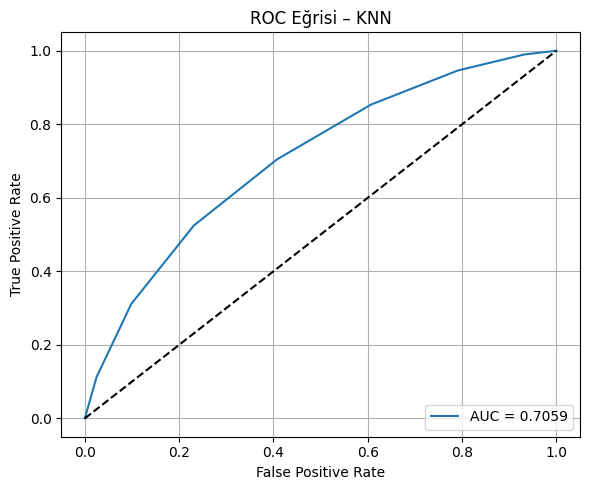

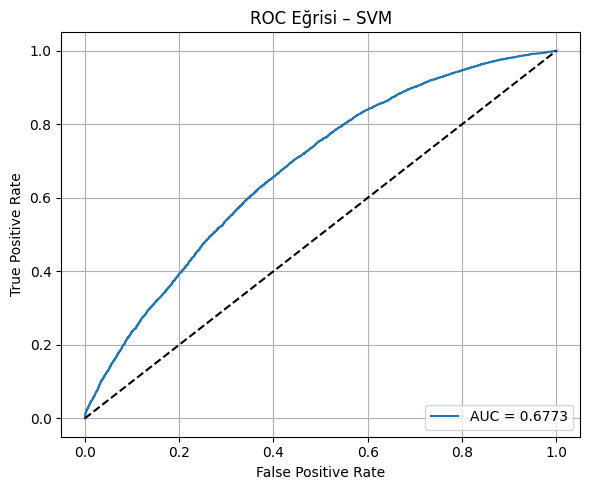

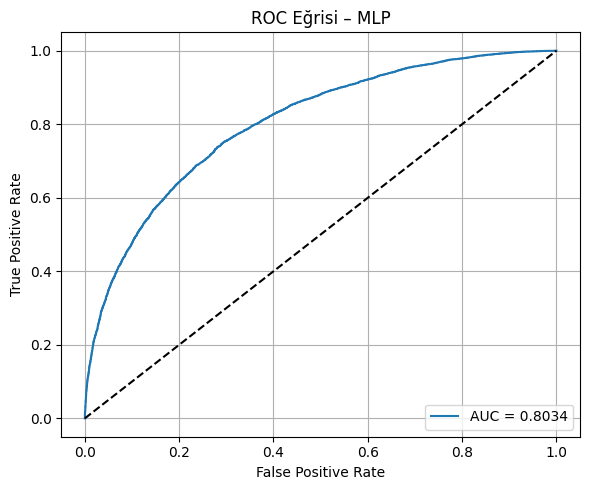

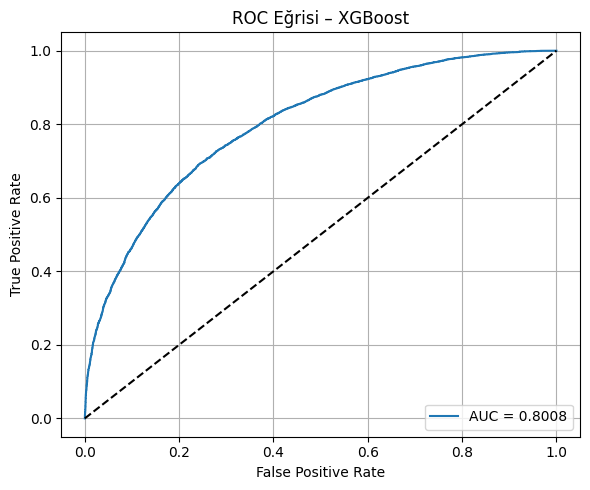

In [25]:
# ROC Eğrileri – Her Model İçin Ayrı Ayrı Çizim
for model_name, model in fitted_final_models.items():
    plt.figure(figsize=(6, 5))
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_selected)[:, 1]
    else:
        y_proba = model.decision_function(X_test_selected)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Eğrisi – {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


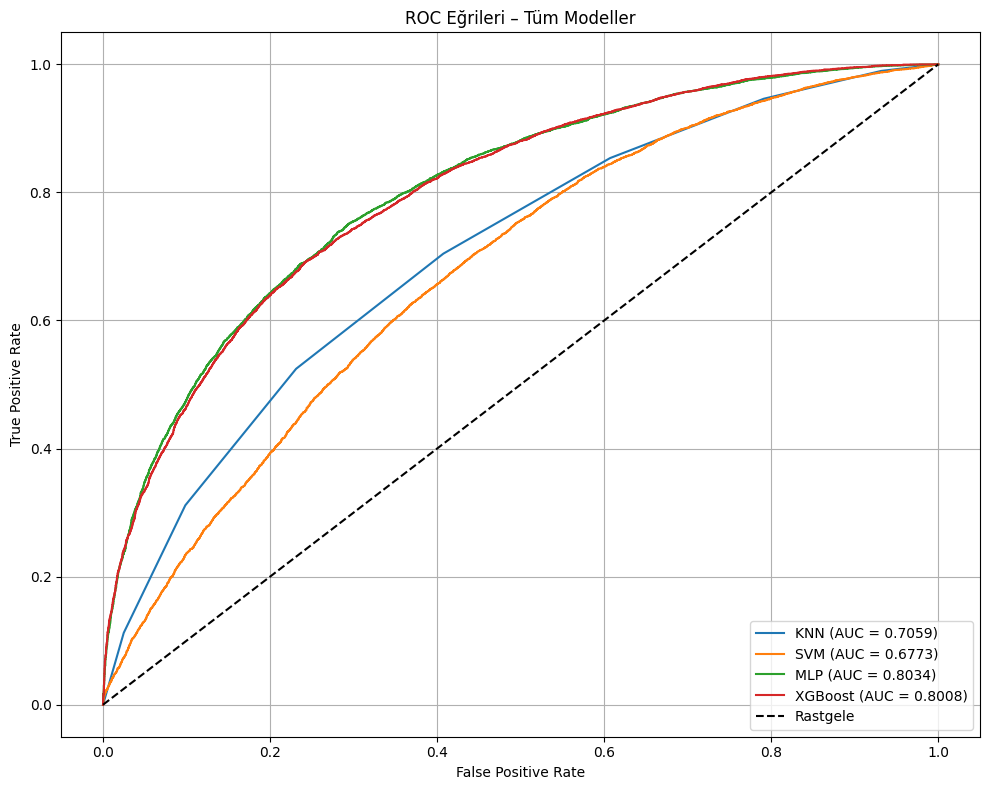

In [26]:
# ROC Eğrileri – Tüm Modeller Tek Grafikte
plt.figure(figsize=(10, 8))
for model_name, model in fitted_final_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_selected)[:, 1]
    else:
        y_proba = model.decision_function(X_test_selected)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Rastgele")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri – Tüm Modeller")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
